# "Whitening" pulsar residuals by substacting the best estimate for the Fourier coefficients describing the involved Gaussian processes

Given a pulsar with its list of TOAs, build a noise model (in this case, we include white noise (efac + equad), red noise and DM variations (dm_gp)) and compute the best estimate of the Fourier coefficients used to describe the involved Gaussian processes. Subtact the obtained waveform model from the residuals to obtain the "whitened" residuals.

Notebook based on functions included in the package **la_forge** (https://github.com/nanograv/la_forge)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals.selections import no_selection, Selection
from enterprise.signals import parameter, white_signals, utils, gp_signals, signal_base
import enterprise.constants as const

import la_forge.gp as lfgp

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


<ErrorbarContainer object of 3 artists>

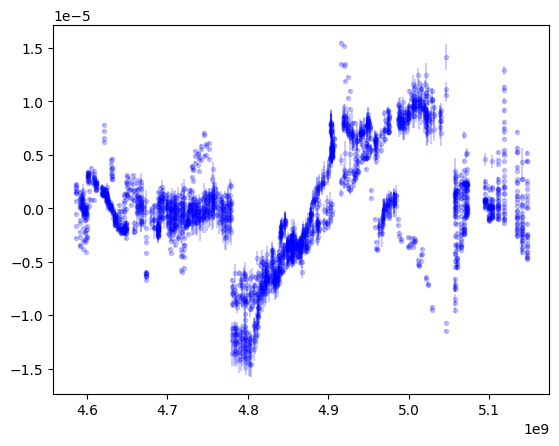

In [2]:
# directories
home_dir = './'
name = 'J1939+2134'

# pulsar
par_dir = home_dir + name + '.par'
tim_dir = home_dir + name + '.tim'
psr = Pulsar(par_dir,tim_dir)

# residual plot
plt.errorbar(psr.toas,psr.residuals,yerr=psr.toaerrs,fmt='.',alpha=0.2, color='blue')

I decide to include in my noise model:
- white noise: efac + equad specific for each observing backend
- red noise (spectrum modeled as a flat tail powerlaw)
- DM variations: dm_gp (spectrum modeled as a flat tail powerlaw)

All the previous signals are included in the model but with *constant prior* on the hyperparameters. The PTA object will have no free parameters.

**NB:** do not use *MarginalizingTimingModel()*: la_forge function do not include it as option and, therefore, expect different matrix sizes

In [3]:
from enterprise.signals.parameter import function
@function
def powerlaw_flat_tail(f, log10_A=-16, gamma=5, log10_kappa=-7, components=2):
    df = np.diff(np.concatenate((np.array([0]), f[::components])))
    pl = (10**log10_A) ** 2 / 12.0 / np.pi**2 * const.fyr ** (gamma - 3) * f ** (-gamma) * np.repeat(df, components)
    flat = 10 ** (2*log10_kappa)
    return np.maximum(pl, flat)

In [4]:
# single pulsar pta model
# **************************************************************************

def model_spna(psr, tm_marg=False, wn=False, rn=False, dm=False):

    tmin = [psr.stoas.min()]
    tmax = [psr.stoas.max()]
    Tspan = np.max(tmax) - np.min(tmin)

    # timing model
    if tm_marg == True:
        tm = gp_signals.MarginalizingTimingModel(use_svd=True)
    else:
        tm = gp_signals.TimingModel()

    # white noise
    if wn == True:
        efac = parameter.Uniform(0,1)
        equad = parameter.Uniform(-7,-5)
    else:
        efac = parameter.Constant(1.0)
        equad = parameter.Constant(-6)
    ef = white_signals.MeasurementNoise(efac=efac,  selection=Selection(selections.by_backend))
    eq = white_signals.TNEquadNoise(log10_tnequad = equad,  selection=Selection(selections.by_backend))

    # red noise
    if rn == True:
        rn_log10_A = parameter.Uniform(-18, -12)
        rn_gamma = parameter.Uniform(0,7)
        rn_log10_kappa = parameter.Uniform(-9,-5)
        rn_pl = powerlaw_flat_tail(log10_A=rn_log10_A, gamma=rn_gamma, log10_kappa=rn_log10_kappa)
        rn = gp_signals.FourierBasisGP(spectrum=rn_pl, components=30, Tspan=Tspan)
    else:
        rn_log10_A = parameter.Constant(-11)
        rn_gamma = parameter.Constant(5)
        rn_log10_kappa = parameter.Constant(-6)
        rn_pl = powerlaw_flat_tail(log10_A=rn_log10_A, gamma=rn_gamma, log10_kappa=rn_log10_kappa)
        rn = gp_signals.FourierBasisGP(spectrum=rn_pl, components=30)

    # DM variations (dm_gp)
    if dm == True:
        dm_log10_A = parameter.Uniform(-18, -12)
        dm_gamma = parameter.Uniform(0,7)
        pl_dm = utils.powerlaw(log10_A=dm_log10_A, gamma=dm_gamma)
    else:
        dm_log10_A = parameter.Constant(-12)
        dm_gamma = parameter.Constant(4)
        dm_log10_kappa = parameter.Constant(-6)
        pl_dm = powerlaw_flat_tail(log10_A=dm_log10_A, gamma=dm_gamma, log10_kappa=dm_log10_kappa)
    dm_basis = utils.createfourierdesignmatrix_dm(nmodes=100)
    dm = gp_signals.BasisGP(priorFunction=pl_dm, basisFunction=dm_basis, name='dm')

    # final model
    model = ef + eq + tm + rn + dm

    return model(psr)

In [5]:
pta = signal_base.PTA([model_spna(psr)])
print(pta.params)                 # expected to be empty
print(pta._signalcollections [0]) # follows the order of model definition

[]
<Enterprise SignalCollection object J1939+2134: measurement_noise, tnequad, linear_timing_model, red_noise, dm>


### la_forge functions for the recovery of the Fourier coefficients 

In [6]:
def get_b(d, TNT, phiinv):
    Sigma_inv = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
    try:
        L = sl.cholesky(Sigma_inv, lower=True)
        coeffs = sl.cho_solve((L, True), d)   # maximum likelihood estimates 

    except np.linalg.LinAlgError:
        Q, R = sl.qr(Sigma_inv)
        Sigi = sl.solve(R, Q.T)
        coeffs = np.dot(Sigi, d)      # maximum likelihood estimates 

    return coeffs


def reconstruct_coeffs(self, mlv=False, idx=None):
    """
    Parameters
    ----------
    mlv : bool
        Whether to use the maximum likelihood value for the reconstruction.

    idx : int, optional
        Index of the chain array to use.

    Returns
    -------
    wave : array
        A reconstruction of a single gaussian process signal realization.
    """

    if idx is None:
        idx = np.random.randint(self.burn, self.chain.shape[0])
    elif mlv:
        idx = self.mlv_idx

    # get parameter dictionary
    params = self.sample_posterior(idx)
    self.idx = idx
    coeffs = []

    TNrs, TNTs, phiinvs, Ts = self._get_matrices(params=params)

    for (p_ct, psrname, d, TNT, phiinv, T) in zip(self.p_idx, self.p_list,
                                                    TNrs, TNTs, phiinvs, Ts):
        coeffs.append(get_b(d, TNT, phiinv))

    return coeffs

In [7]:
## FOURIER COEFFS ESTIMATES
chain = np.zeros((1000,4))
lfrec = lfgp.Signal_Reconstruction([psr], pta, chain, burn=0)
wave = lfgp.Signal_Reconstruction.reconstruct_signal(lfrec, gp_type='all', det_signal=False, mlv=True, idx=None, condition=False, eps=1e-16)
print(wave)

{'J1939+2134': array([ 1.20327368e-06,  1.43172426e-06,  1.68370998e-06, ...,
       -4.24972603e-06, -3.38143613e-06, -1.83636410e-06])}


In [8]:
# from dictionary to array
a_wave = np.array(wave[psr.name])

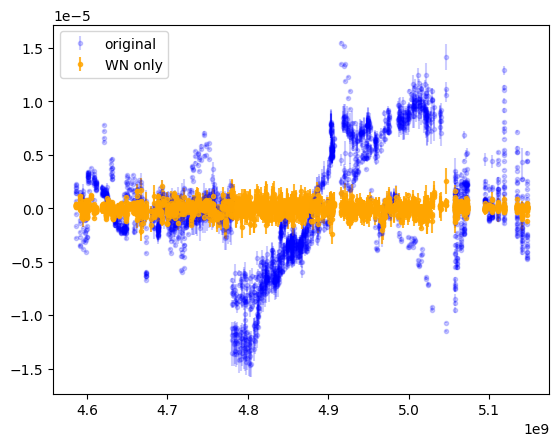

In [9]:
# comparing the original TOAs (blue) with the whitened ones (orange)
plt.errorbar(psr.toas,psr.residuals,yerr=psr.toaerrs,fmt='.',alpha=0.2, color='blue', label='original')
plt.errorbar(psr.toas,psr.residuals-a_wave,yerr=psr.toaerrs,fmt='.',alpha=0.8, color='orange', label='WN only')
plt.legend()